### Diese Zelle installiert das efficientnet, die Grundlage unseres Modells.

*(Das Ausrufezeichen bedeutet, dass der Befehl in der Kommandozeile ausgeführt wird, und es sich nicht um Python-Code handelt)*

In [1]:
#Dieses Paket enthält auch vortrainierte Netze, die man verwenden kann, um Hunde und Katzen auseinanderzuhalten
!pip install -U efficientnet

     |████████████████████████████████| 51kB 3.9MB/s 


In [3]:
# In dieser Zelle werden alle benötigten Pakete importiert.
import matplotlib.pyplot as plt
import efficientnet.keras as efn
import os
from cv2 import imread
from efficientnet.keras import center_crop_and_resize, preprocess_input
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
from scipy.spatial.distance import euclidean
import random
import requests
from tensorflow.keras.models import load_model
import math

import zipfile

import tensorflow as tf


In [17]:
# Die Konstante IMAGE_SIZE bestimmt die Auflösung der verwendeten Bilder.
# Je höher die Auflösung, desto genauer die Vorhersage, und desto länger dauert diese.
IMAGE_SIZE = 350

# Benötigte Funktionen

Die Funktionen in diesem Abschnitt ermöglichen bzw. erleichtern das Arbeiten mit dem Modell. 

In [4]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss von Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [5]:
def predict_vector_distance(img1, img2):
    '''predicts the euclidian vector distance between two cat images.
    img1: preprocessed image with cat 1
    img2: preprocessed image with cat 2
    returns: floating point value of euclidian distance'''
    
    img1 = np.expand_dims(img1, 0)
    img2 = np.expand_dims(img2, 0)
    return model.predict([img1, img2]).item()

In [6]:
def predict_vector_of_single_image(img):
    '''predicts a feature vector of a single image
    img: preprocessed image to calculate the vector from.
    returns: 128-dimensional vector'''

    img = np.expand_dims(img, 0)
    return base_model.predict(img)[0]

In [7]:
def center_crop(img):
    width, height = img.size
    new_width, new_height = width, height
    if width > height:
        new_width = height
    else:
        new_height = width
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    return img.crop((left, top, right, bottom))

In [8]:
def load_and_preprocess_image(path):
    '''loads an image and preprocesses it.
    path: path leading to the image file.
    returns: numpy array with preprocessed image'''
    img = np.array(Image.open(path))
    if img is not None: 
        img = center_crop_and_resize(img, image_size=IMAGE_SIZE)
        try:
            reshaped = preprocess_input(img).reshape(IMAGE_SIZE, IMAGE_SIZE, 3)
        except ValueError:
            return None
        return reshaped
    else: return None

In [9]:
def load_image(path):
    return np.array(center_crop(Image.open(path)))

In [10]:
def sort_cats_by_similarity_with_vectors(reference, imgs, vects):
    '''Sorts a list of cats by similarity using already calculated feauture vectors.
    This can be used e.g. to sort lost reports on websites or in apps like www.tasso.net efficiently.
    reference: List with one or more images of the cat the other images should be compared with
    imgs: list of cats; each cat is a list of one or more images.
    vects: list of cats; each cat is a list of one or more vectors of the images in imgs.
    returns: list of sorted cats.'''

    # calculate feauture vectors for the reference cat
    ref_vects = base_model.predict(np.array(reference))

    # calculate the vector distances between each cat images and the reference images
    distances = []
    for cat_vects in vects:
        cat_dists = [np.mean(euclidean(vect, ref_vect)) for vect in cat_vects for ref_vect in ref_vects]
        distances.append(np.mean(cat_dists))

    # sort the cat images by their vector distances  
    indices = np.argsort(distances)
    return np.take_along_axis(np.array(imgs), indices, axis=0)

# Modell
Dieser Abschnitt lädt das Modell aus unserem GitHub Repository herunter und speichert es ab. Der Speicherort wird mit der Variable *path_to_model* festgelegt.

In [11]:
path_to_model = 'model.h5'
r = requests.get('https://raw.github.com/Leonard-P/Catlab/main/model.h5')
open(path_to_model, 'wb').write(r.content)

17229760

In [12]:
# Das abgespeicherte Netz wird geladen und in der Variable model gespeichert.
model = load_model(path_to_model, compile=False)
# Eine "Hälfte" des siamesischen Netzes wird in der Variable base_model gespeichert,
# um auch nur die Vektoren von Bildern berechnen zu können
base_model = model.layers[2]

### Dieser Abschnitt lädt Bilder zum Testen.
Um Bilder aus einem anderen Ordner zu laden, kann die Variable path verändert werden. Falls am angegebenem Ort keine Bilder existieren, wird der Cats vs. Dogs Datensatz aus dem Internet geladen. Allerdings befindet sich darin von jeder Katze nur ein Bild.

In [15]:
save_path = '/content/cats'

# Die Anzahl der in den Zwischenspeicher zu ladenden Bilder. Ab ca. 2000 Bildern
# läuft der Arbeitsspeicher über.
amount_of_images = 1000

if not os.path.isdir(save_path): 
    os.mkdir(save_path)
url = 'https://downloads.codingcoursestv.eu/037%20-%20neuronale%20netze/PetImages.zip'
r = requests.get(url, stream=True)
total_size = int(r.headers.get('content-length', 0)); 
block_size = 1024 
with open(os.path.join(save_path, 'PetImages.zip'), 'wb') as f:
    for data in tqdm(r.iter_content(block_size), total=math.ceil(total_size//block_size), unit='KB', unit_divisor=1024, unit_scale=True, desc='Lade Cats vs. Dogs'):
        f.write(data)
print('Zip-Archiv wird extrahiert...')
zip_ref = zipfile.ZipFile(os.path.join(save_path, 'PetImages.zip'), 'r')
zip_ref.extractall(os.path.join(save_path))
zip_ref.close()
path = os.path.join(save_path, 'PetImages/Cat')
print('Datensatz wurde geladen.')
    
filenames = os.listdir(path)
if amount_of_images < len(filenames) and amount_of_images:
    filenames = filenames[:amount_of_images]


Zip-Archiv wird extrahiert...
Datensatz wurde geladen.


In [18]:
# cats_preprocessed ist die Liste mit Bildern, die bereist für die Vorhersage aufbereitet sind.
# Da durch das preprocessing u.A. die Farben des Bildes verändert werden,
# wird jedes Bild nochmals ohne preprocessing in der Liste cats abgespeichert.
# Bilder ohne preprocessing sollten aber nicht zur Vorhersage verwendet werden.
cats_preprocessed = []
cats = []

# laedt die Bilder und bereitet sie für das Neuronale Netz vor
for filename in tqdm(filenames):
    img = load_and_preprocess_image(os.path.join(path, filename))
    if img is not None: 
        cats_preprocessed.append(img)
        cats.append(load_image(os.path.join(path, filename)))

### Von den geladenen Bildern werden nun die Vektoren berechnet. 
Möchte man nun Bilder nach Ähnlichkeit sortieren, sind die Vektoren bereits berechnet, sodass nur noch Zahlenwerte abgeglichen werden müssen.

In [19]:
# Dies dauert beim ersten Ausführen etwas länger, da das Modell instanziert werden muss.
vecs = base_model.predict(
        np.array(cats_preprocessed)
    ).reshape((len(cats_preprocessed), 1, 128))

## 3. Bilder sortieren
Dieser Abschnitt erzeugt Beispiele das Sortieren der Bilder (genau wie in unserer Präsentation).

Bei jedem Ausführen wird die Liste der Katzen anhand eines neuen Beispiels sortiert.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


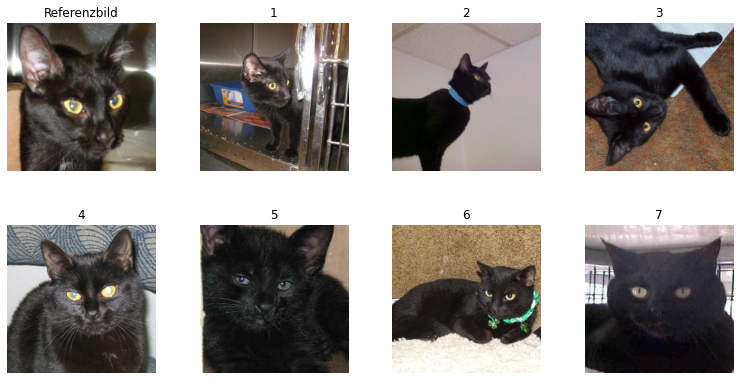

In [23]:
# zufälliges Referenzbild wählen
reference_index = random.randint(0, len(filenames))
# Katzen sortieren
cats_sorted = sort_cats_by_similarity_with_vectors([cats_preprocessed[reference_index]], cats, vecs)

# Die ähnlichsten Katzen anzeigen
plt.figure(figsize=(13, 13))
for i, image in enumerate(cats_sorted[:8]):
    ax = plt.subplot(2, 4, i+1)
    plt.imshow(image)
    plt.title(str(i) if i!= 0 else 'Referenzbild')
    plt.axis('off')

plt.subplots_adjust(hspace=-0.6, wspace = 0.3)